<a href="https://colab.research.google.com/github/Lucalangella/HandAnchorDebuggingVisionOS/blob/main/notebooks/train_model_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- BLOCK 1: SETUP (Fix Dependency Hell) ---
import os

# 1. Force install compatible versions (NumPy 1.x + Old FastAI)
print("Installing compatible libraries... (This may take a moment)")
# We specifically request "numpy<2" to prevent the crash you just saw
!pip install -Uqq "numpy<2" fastai==2.7.14 fastprogress==1.0.3 coremltools

# 2. Check if we need to restart to apply changes
try:
    import numpy
    # If numpy is already loaded and is version 2+, we MUST restart
    if numpy.__version__.startswith('2'):
        print("⚠️ Incompatible NumPy detected. Restarting runtime automatically...")
        os.kill(os.getpid(), 9)
except ImportError:
    pass

import shutil
from pathlib import Path
from fastai.vision.all import *

# 3. Clean up old runs
repo_name = "tennis-court-classifier"
if os.path.exists(repo_name):
    shutil.rmtree(repo_name)

# 4. Clone your repository
user = "LucaLangella"
print(f"Cloning repository from user: {user}...")
!git clone https://github.com/{user}/{repo_name}.git

# 5. Define path
path = Path(f'./{repo_name}/tennis_courts')
print(f"✅ Setup complete. Data path set to: {path}")

Installing compatible libraries... (This may take a moment)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 98.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.36.3 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 require

In [1]:
# --- BLOCK 1.5: VERIFY SETUP ---
import numpy
import fastai
import coremltools

print(f"✅ NumPy Version: {numpy.__version__}")
# WE WANT: 1.26.4 (or anything starting with 1.)

print(f"✅ FastAI Version: {fastai.__version__}")
# WE WANT: 2.7.14

print("Refinding your data...")
from fastai.vision.all import *
path = Path('./tennis-court-classifier/tennis_courts')

if path.exists():
    print(f"✅ Data still there! Found {len(get_image_files(path))} images.")
else:
    print("⚠️ Data was wiped by the restart. Please Run 'Block 1' again (The Setup Block).")

✅ NumPy Version: 1.26.4
✅ FastAI Version: 2.7.14
Refinding your data...
✅ Data still there! Found 155 images.


In [2]:
# --- BLOCK 2: FIX EMPTY FOLDERS ---
from fastai.vision.all import *

# 1. Ensure the 'unknown' folder exists
unknown_folder = path / 'unknown'
unknown_folder.mkdir(parents=True, exist_ok=True)

# 2. check if it needs images
if len(get_image_files(unknown_folder)) < 10:
    print("⚠️ 'Unknown' folder is empty. Downloading junk images...")

    # Download Imagenette (random object dataset)
    path_random = untar_data(URLs.IMAGENETTE_160)

    # Copy 50 random images to your unknown folder
    random_files = get_image_files(path_random/'train')[:50]
    for i, file in enumerate(random_files):
        shutil.copy(file, unknown_folder / f'random_{i}.jpg')

    print(f"✅ Added {len(random_files)} images to 'unknown' folder.")
else:
    print(f"✅ 'Unknown' folder already has {len(get_image_files(unknown_folder))} images.")

✅ 'Unknown' folder already has 50 images.


In [13]:
# --- BLOCK 3: TRAIN MODEL ---
# 1. Load Data
dls = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(224, method='squish'),
    batch_tfms=aug_transforms(mult=1.5),
    bs=32,
    num_workers=2
)

print(f"Classes found: {dls.vocab}")
# VERIFY: Should be ['clay', 'grass', 'hard', 'unknown']

# 2. Create Learner
learn = vision_learner(dls, resnet18, metrics=error_rate)

# 3. Train
print("\nStarting training...")
# FIX: The line below must NOT have spaces at the start
learn.fine_tune(4)

print("✅ Training complete!")

Classes found: ['clay', 'grass', 'hard', 'unknown']

Starting training...


epoch,train_loss,valid_loss,error_rate,time
0,1.883326,0.866762,0.258065,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.564020,0.423802,0.225806,00:14
1,0.424925,0.443778,0.193548,00:13
2,0.322927,0.383889,0.193548,00:13
3,0.277384,0.331417,0.193548,00:13


✅ Training complete!


Displaying predictions (Green = Correct, Red = Mistake)...


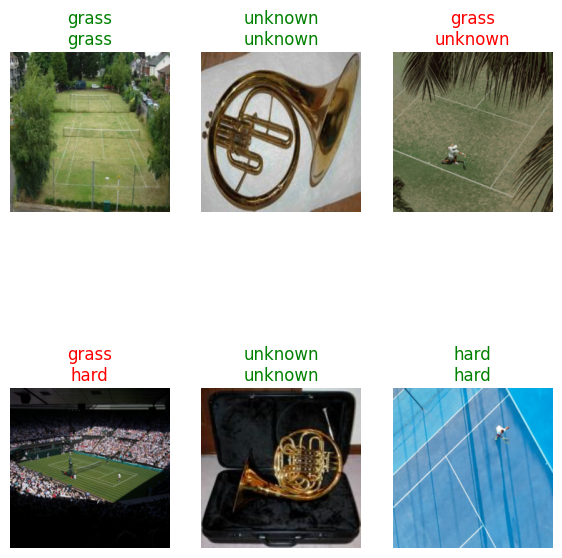

In [4]:
# --- BLOCK 3.5: SHOW VISUAL RESULTS ---
# Show 6 examples from the validation set
# Top label = True Class, Bottom label = AI's Prediction
print("Displaying predictions (Green = Correct, Red = Mistake)...")
learn.show_results(max_n=6, figsize=(7, 8))

In [5]:
# --- BLOCK 4: EXPORT TO COREML ---
import coremltools as ct
import torch
from google.colab import files

print("Converting model to CoreML...")

# 1. Prepare model for export (CPU mode)
model = learn.model.eval().cpu()
dummy_input = torch.rand(1, 3, 224, 224)
traced_model = torch.jit.trace(model, dummy_input)

# 2. Convert
mlmodel = ct.convert(
    traced_model,
    inputs=[ct.ImageType(
        name="image",
        shape=dummy_input.shape,
        scale=1/255.0,
        bias=[-0.485/0.229, -0.456/0.224, -0.406/0.225]
    )],
    classifier_config=ct.ClassifierConfig(list(dls.vocab))
)

# 3. Save & Zip
mlmodel.short_description = "Tennis Court Classifier"
mlmodel.author = "Luca"
save_name = "TennisClassifier_Colab.mlpackage"
mlmodel.save(save_name)

print("✅ Model saved! Zipping...")
zip_name = "TennisClassifier_Final"
shutil.make_archive(zip_name, 'zip', save_name)

# 4. Download
print("⬇️ Downloading file...")
files.download(f"{zip_name}.zip")

Converting model to CoreML...


Running MIL default pipeline:   0%|          | 0/95 [00:00<?, ? passes/s]/usr/local/lib/python3.12/dist-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:273: UserWarning: Output, '358', of the source model, has been renamed to 'var_358' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 368.60 passes/s]


✅ Model saved! Zipping...
⬇️ Downloading file...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# --- BLOCK 4.5: RUN EXAM ON GITHUB DATA ---
import os
from fastai.vision.all import *

# 1. Point to your specific folder from GitHub
repo_name = "tennis-court-classifier"
test_path = Path(f'./{repo_name}/test_images_set')

# 2. Verify the files are there
if test_path.exists():
    files_found = get_image_files(test_path)
    print(f"✅ FOUND TEST SET: {len(files_found)} images")

    # 3. Run Predictions
    print("\n--- GRADING YOUR MODEL ---")

    test_dl = learn.dls.test_dl(files_found)
    preds, _ = learn.get_preds(dl=test_dl)

    for i, file in enumerate(files_found):
        predicted_index = preds[i].argmax()
        predicted_label = dls.vocab[predicted_index]
        confidence = preds[i][predicted_index] * 100

        flag = "⚠️" if confidence < 60 else "✅"
        print(f"{flag} File: {file.name.ljust(20)} --> Predicted: {predicted_label.upper().ljust(10)} ({confidence:.1f}%)")

else:
    print(f"❌ ERROR: Could not find folder at {test_path}")
    print("You may need to run 'Block 1' again to re-download the updated repo.")

✅ FOUND TEST SET: 17 images

--- GRADING YOUR MODEL ---


⚠️ File: test_clay_1.png      --> Predicted: HARD       (50.8%)
✅ File: test_clay_2.png      --> Predicted: CLAY       (89.9%)
✅ File: test_random_9.jpg    --> Predicted: UNKNOWN    (99.9%)
✅ File: test_hard_3.png      --> Predicted: CLAY       (93.6%)
✅ File: test_random_5.jpg    --> Predicted: UNKNOWN    (97.5%)
✅ File: test_random_7.jpg    --> Predicted: UNKNOWN    (97.6%)
✅ File: test_random_3.jpg    --> Predicted: UNKNOWN    (99.5%)
✅ File: test_random_6.jpg    --> Predicted: UNKNOWN    (99.9%)
✅ File: test_random_8.jpg    --> Predicted: UNKNOWN    (89.7%)
✅ File: test_clay_3.png      --> Predicted: CLAY       (74.1%)
✅ File: test_random_2.jpg    --> Predicted: UNKNOWN    (100.0%)
⚠️ File: test_hard_1.png      --> Predicted: HARD       (59.5%)
✅ File: test_random_1.jpg    --> Predicted: UNKNOWN    (100.0%)
✅ File: test_hard_2.png      --> Predicted: HARD       (96.2%)
✅ File: test_random_0.jpg    --> Predicted: UNKNOWN    (100.0%)
⚠️ File: test_grass_1.png     --> Predicted: HARD 

Generating Confusion Matrix...



Top 5 Biggest Mistakes:


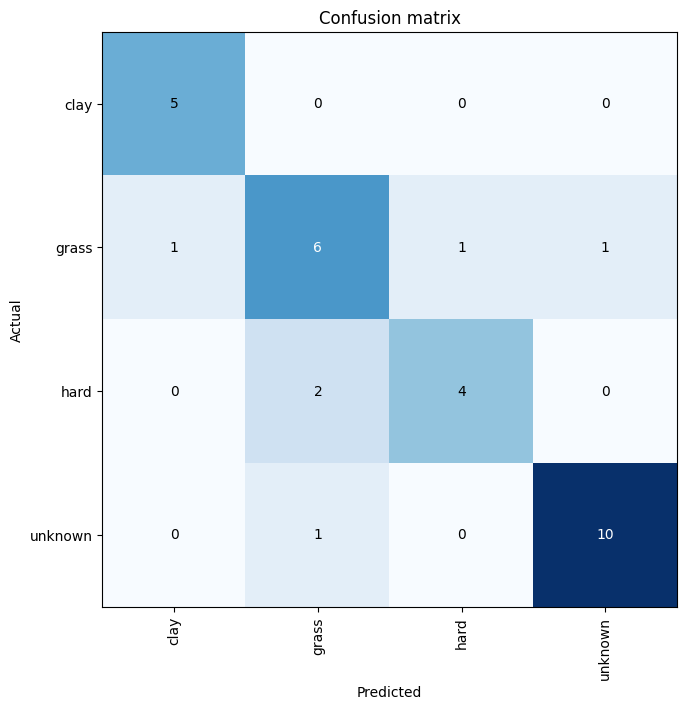

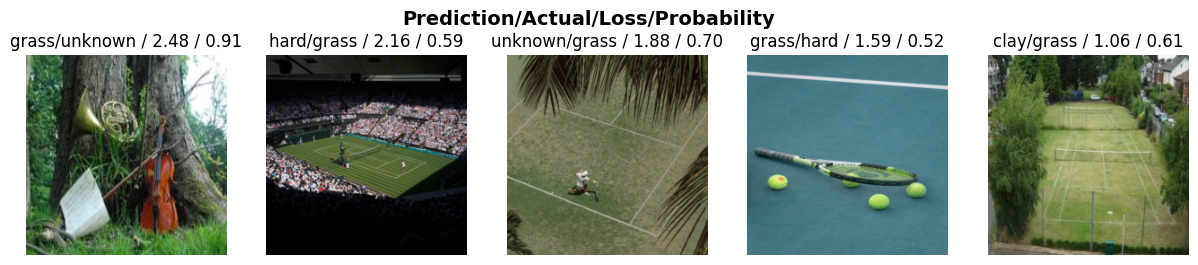

In [14]:
# --- BLOCK 5: ANALYZE RESULTS ---
from fastai.vision.all import *

# 1. create an interpreter to look at errors
interp = ClassificationInterpretation.from_learner(learn)

# 2. Plot the Confusion Matrix
print("Generating Confusion Matrix...")
interp.plot_confusion_matrix(figsize=(7, 7))

# 3. Show the top 5 worst mistakes (highest confidence errors)
print("\nTop 5 Biggest Mistakes:")
interp.plot_top_losses(5, nrows=1)

In [11]:
# --- BLOCK 6: INTERACTIVE TEST ---
import ipywidgets as widgets
from PIL import Image
import io

# 1. Create the upload button
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

def on_data_change(change):
    lbl_pred.value = ''

    # Get the uploaded image
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(224,224))

    # Predict
    pred, pred_idx, probs = learn.predict(img)

    # Show result
    lbl_pred.value = f'PREDICTION: {pred.upper()} (Confidence: {probs[pred_idx]*100:.2f}%)'

# Link the button to the function
btn_upload.observe(on_data_change, names=['data'])

# Display the widget
print("Click 'Upload' to test a new image:")
display(widgets.VBox([btn_upload, out_pl, lbl_pred]))

Click 'Upload' to test a new image:
